# Final Project: Kobe Bryant Shot Selection

Can you predict which shots will find the bottom of the net, using classification basics, feature engineering, and time series analysis?

In [2]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm

/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
# force Pandas to display all columns
pd.set_option("display.max_columns", None)

In [4]:
# read in data
# data contains location and circumstances of every field goal attempted by Kobe
# using this data, predict whether the basket went in (shot_made_flag)
data = "data.csv"
# sample_submission = "sample_submission.csv"

d = pd.read_csv(data)
# sam = pd.read_csv(sample_submission)

In [5]:
# examine data
d.head(5)

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


## Exploratory Data Analysis

We look at some of the interesting variables.  

**Interesting variables:**  
    action_type  
    combined_shot_type  
    loc_x (or lat)  
    loc_y (or lot)  
    minutes_remaining + seconds_remaining  
    period  
    playoffs  
    season  
    shot_distance  
    shot_type  
    shot_zone_area  
    shot_zone_basic  
    shot_zone_range  
    opponent  

In [86]:
d1 = d[["shot_made_flag", "action_type", "combined_shot_type", "loc_x", "loc_y", "minutes_remaining", "seconds_remaining", "period", "playoffs", "season", "shot_distance", "shot_type", "shot_zone_area", "shot_zone_basic", "shot_zone_range", "opponent"]]

### Action type

In [7]:
# number of different action types
len(d1["action_type"].unique())

57

In [8]:
d1["action_type"].value_counts()

Jump Shot                             18880
Layup Shot                             2567
Driving Layup Shot                     1978
Turnaround Jump Shot                   1057
Fadeaway Jump Shot                     1048
Running Jump Shot                       926
Pullup Jump shot                        476
Turnaround Fadeaway shot                439
Slam Dunk Shot                          411
Reverse Layup Shot                      395
Jump Bank Shot                          333
Driving Dunk Shot                       310
Dunk Shot                               262
Tip Shot                                182
Alley Oop Dunk Shot                     122
Step Back Jump shot                     118
Floating Jump shot                      114
Driving Reverse Layup Shot               97
Hook Shot                                84
Driving Finger Roll Shot                 82
Alley Oop Layup shot                     80
Reverse Dunk Shot                        75
Running Layup Shot              

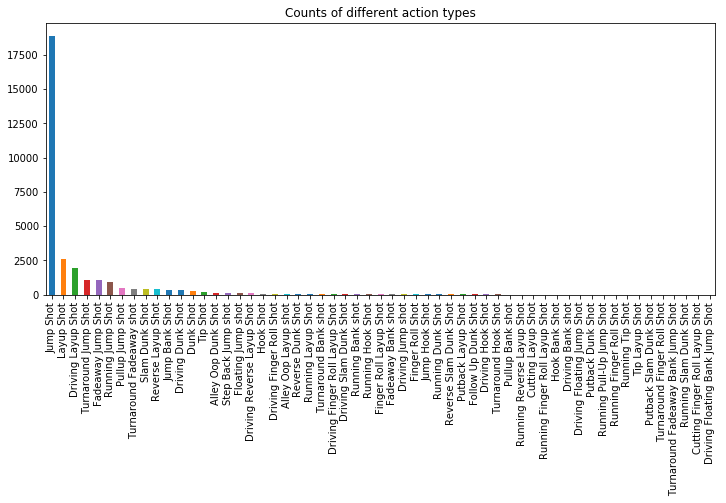

In [9]:
# bar plot of counts of different action types
d1["action_type"].value_counts().plot.bar(figsize=(12,5)).set_title("Counts of different action types")
plt.show()

In [87]:
# there are too many kinds of action types with very low counts!
# group all action type with less than 20 occurences as "Other Shot"
action_type_counts = d1["action_type"].value_counts()
d1.loc[d1["action_type"].isin(action_type_counts.index[action_type_counts<20]), 'action_type'] = "Other Shot"

In [12]:
# fewer action types compared to original 57
len(d1["action_type"].unique())

34

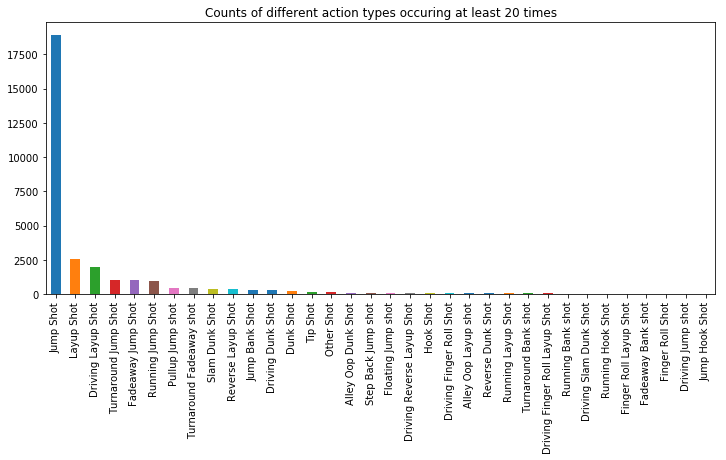

In [13]:
# Updated bar plot
d1["action_type"].value_counts().plot.bar(figsize=(12,5)).set_title("Counts of different action types occuring at least 20 times")
plt.show()

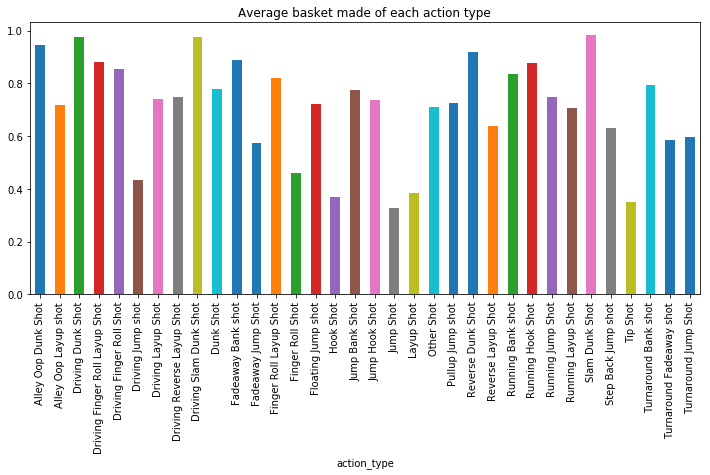

In [14]:
# we then look at how many shots were made on average of each action type
d1["shot_made_flag"].groupby(d1["action_type"]).mean().plot.bar(figsize=(12,5)).set_title("Average basket made of each action type")
plt.show()

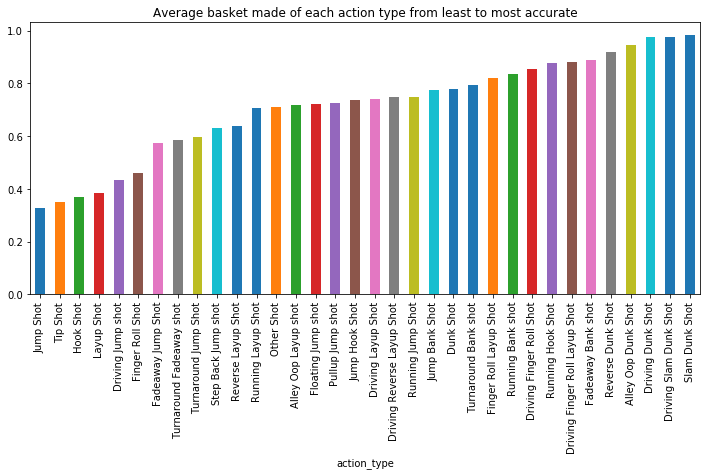

In [15]:
# sorted by least accurate action type to most accurate
d1["shot_made_flag"].groupby(d1["action_type"]).mean().sort_values().plot.bar(figsize=(12,5)).set_title("Average basket made of each action type from least to most accurate")
plt.show()

In [16]:
## we observe correlation between shot_made_flag and action_type

### Combined shot type

In [17]:
# number of different combined shot types
len(d1["combined_shot_type"].unique())

6

In [18]:
d1["combined_shot_type"].value_counts()

Jump Shot    23485
Layup         5448
Dunk          1286
Tip Shot       184
Hook Shot      153
Bank Shot      141
Name: combined_shot_type, dtype: int64

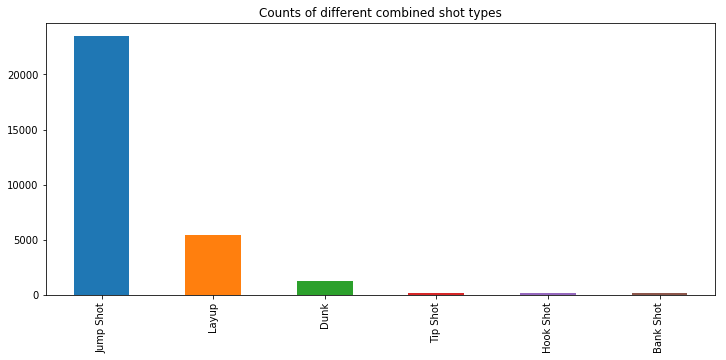

In [19]:
# bar plot of counts of different combined shot types
d1["combined_shot_type"].value_counts().plot.bar(figsize=(12,5)).set_title("Counts of different combined shot types")
plt.show()

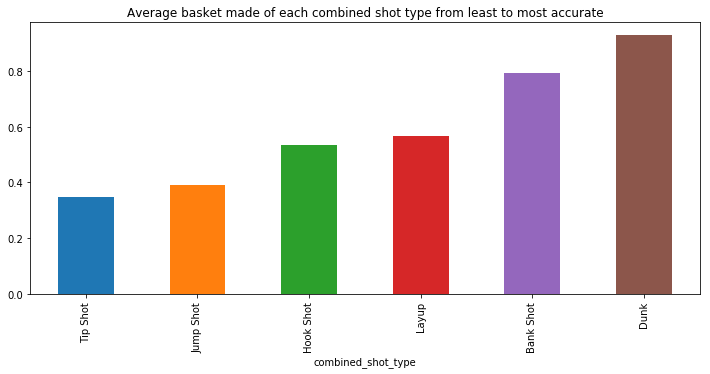

In [20]:
# we look at how many shots were made on average of each combined shot type
# sorted by least accurate action type to most accurate
d1["shot_made_flag"].groupby(d1["combined_shot_type"]).mean().sort_values().plot.bar(figsize=(12,5)).set_title("Average basket made of each combined shot type from least to most accurate")
plt.show()

In [21]:
## similar to actioin_type, we observe correlation between shot_made_flag and combined_shot_type

### Loc x and loc y

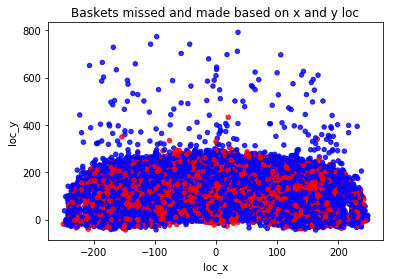

In [22]:
# loc_x = left-right along the endline with 0 centered at the basket)
# loc_y  = positive towards halfcourt with 0 being the basket)
cmap = plt.cm.get_cmap('bwr')
plt.figure(figsize=(7,5))
d1.plot(x="loc_x", y="loc_y", kind='scatter', c = d1["shot_made_flag"].map(cmap), alpha=0.8).set_title("Baskets missed and made based on x and y loc")
plt.show()

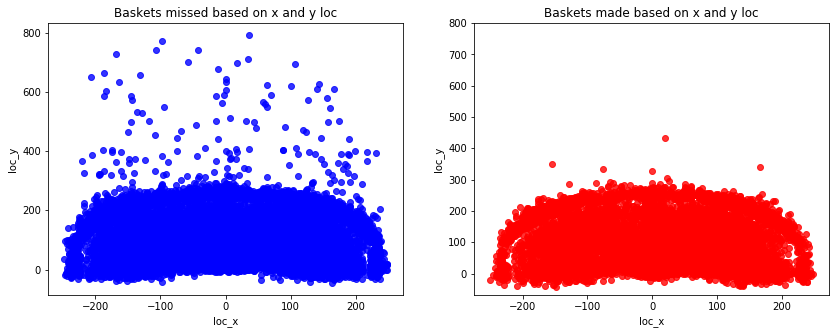

In [23]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.scatter(d1["loc_x"][d1['shot_made_flag']==0], d1["loc_y"][d1['shot_made_flag']==0], c = 'b', alpha=0.8)
plt.xlabel("loc_x")
plt.ylabel("loc_y")
plt.title("Baskets missed based on x and y loc")
plt.subplot(1,2,2)
plt.scatter(d1["loc_x"][d1['shot_made_flag']==1], d1["loc_y"][d1['shot_made_flag']==1], c = 'r', alpha=0.8)
plt.ylim(ymax=800)
plt.xlabel("loc_x")
plt.ylabel("loc_y")
plt.title("Baskets made based on x and y loc")
plt.show()

In [88]:
## location matters especially when Kobe is far from the basket
# group coordinates into clusters using GMM
loc_x_y = GaussianMixture(n_components=10, covariance_type="full")
loc_x_y.fit(d1.loc[:,("loc_x", "loc_y")])
d1.loc[:,"loc_cluster"] = loc_x_y.predict(d1.loc[:,("loc_x", "loc_y")])

### Minutes remaining + seconds remaining

In [89]:
# combine two time variables as total seconds
d1.loc[:,"time_remaining"] = (d1.loc[:,"minutes_remaining"]*60) + d1.loc[:,"seconds_remaining"]

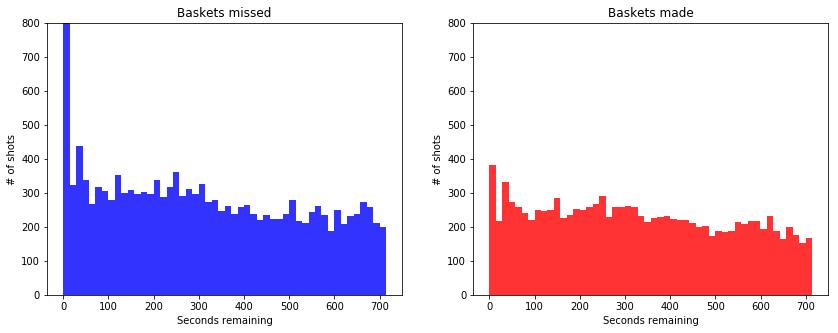

In [27]:
# we look at how many shots were made with how many seconds remaining in the game
# sorted by least accurate action type to most accurate
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.hist(d1["time_remaining"][d1['shot_made_flag']==0], bins = 50, color = 'b', alpha=0.8)
plt.ylim(ymax=800)
plt.xlabel("Seconds remaining")
plt.ylabel("# of shots")
plt.title("Baskets missed")
plt.subplot(1,2,2)
plt.hist(d1["time_remaining"][d1['shot_made_flag']==1], bins = 50, color = 'r', alpha=0.8)
plt.ylim(ymax=800)
plt.xlabel("Seconds remaining")
plt.ylabel("# of shots")
plt.title("Baskets made")
plt.show()

In [33]:
## there are similar number of baskets made and missed except for when there are
## only few seconds remaining. Arbitrary for now, but we can set a boolean for whether
## the shot was made in the last 3 seconds

In [90]:
d1.loc[:,'made_in_last_3'] = d1.loc[:,'time_remaining']<=3

### Period

In [29]:
d1["period"].value_counts().sort_values()

7       7
6      38
5     330
2    6718
4    7260
1    8048
3    8296
Name: period, dtype: int64

In [37]:
## basketball games are played on four quarters/periods but we see that the data goes 
## up to 7th period. We can assume that periods 5-7 are overtime periods, which lasts 
## about half the time of regular periods. It also makes sense that there are 
## significnatly less counts of periods 5-7 above. 

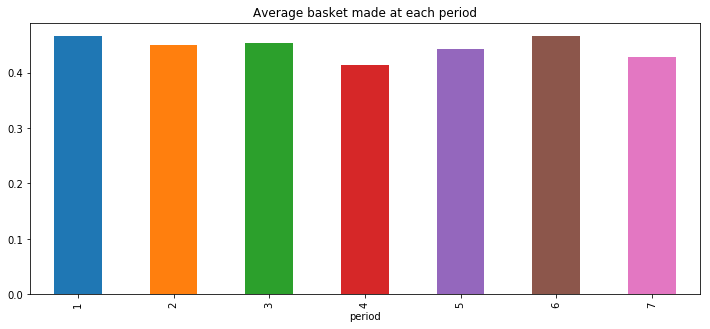

In [30]:
# we look at how many shots were made at each period
# sorted by least accurate action type to most accurate
d1["shot_made_flag"].groupby(d1["period"]).mean().plot.bar(figsize=(12,5)).set_title("Average basket made at each period")
plt.show()

### Season

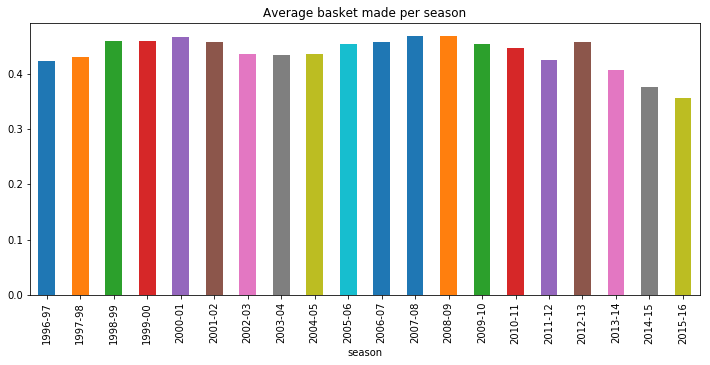

In [31]:
# we look at how many shots were made on average during each season Kobe played
d1["shot_made_flag"].groupby(d1["season"]).mean().plot.bar(figsize=(12,5)).set_title("Average basket made per season")
plt.show()


In [50]:
## We see a gradual decrease in average baskets made per season towards the last
## few years before his retirement. Kobe has previously said in interviews that
## 2012-13 season was his greatest and the season that marked the beginning of 
## the end of his career, which is represented correctly in the plot above.
## Otherwise Kobe was quite consistent throughout his career.

### Shot distance

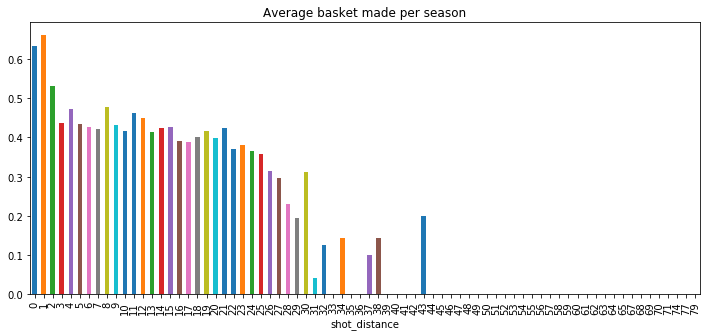

In [32]:
# we look at how many shots were made on average at different distance
d1["shot_made_flag"].groupby(d1["shot_distance"]).mean().plot.bar(figsize=(12,5)).set_title("Average basket made per season")
plt.show()


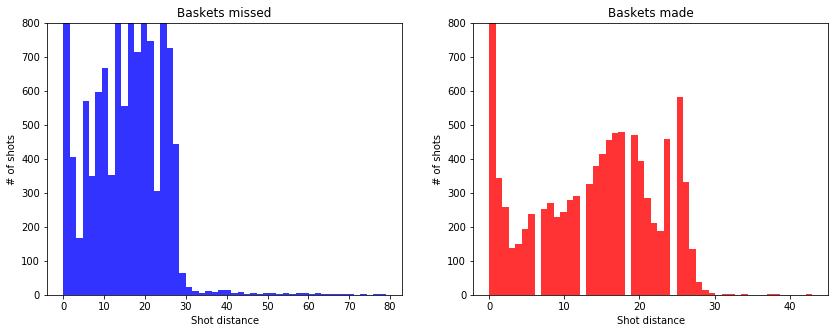

In [33]:
# we also look at how many shots were made from differnet distances from the net
# sorted by least accurate action type to most accurate
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.hist(d1["shot_distance"][d1['shot_made_flag']==0], bins = 50, color = 'b', alpha=0.8)
plt.ylim(ymax=800)
plt.xlabel("Shot distance")
plt.ylabel("# of shots")
plt.title("Baskets missed")
plt.subplot(1,2,2)
plt.hist(d1["shot_distance"][d1['shot_made_flag']==1], bins = 50, color = 'r', alpha=0.8)
plt.ylim(ymax=800)
plt.xlabel("Shot distance")
plt.ylabel("# of shots")
plt.title("Baskets made")
plt.show()

### Shot zone area

In [34]:
# number of different combined shot types
len(d1["shot_zone_area"].unique())

6

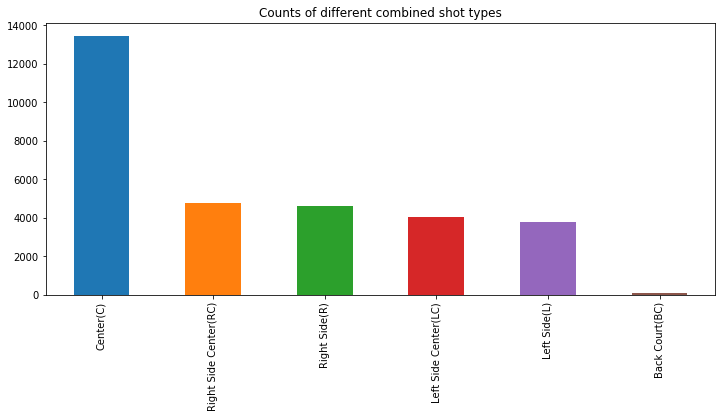

In [35]:
# bar plot of counts of different combined shot types
d1["shot_zone_area"].value_counts().plot.bar(figsize=(12,5)).set_title("Counts of different combined shot types")
plt.show()

In [59]:
## we observe correlation between shot_made_flag and shot_zone_area

### Shot zone basic

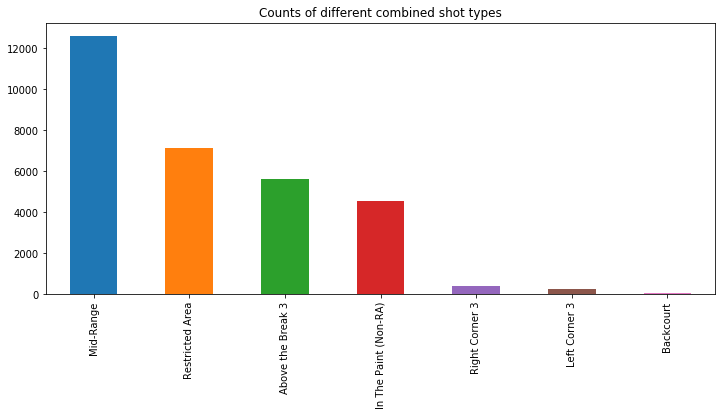

In [36]:
# bar plot of counts of different combined shot types
d1["shot_zone_basic"].value_counts().plot.bar(figsize=(12,5)).set_title("Counts of different combined shot types")
plt.show()

In [61]:
## we observe correlation between shot_made_flag and shot_zone_basic

### Shot zone area

In [ ]:
## shot 

### Transform type object to numerical

In [91]:
d1.head(5)

,shot_made_flag,action_type,combined_shot_type,loc_x,loc_y,minutes_remaining,seconds_remaining,period,playoffs,season,shot_distance,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,opponent,loc_cluster,time_remaining,made_in_last_3
0,NaN,Jump Shot,Jump Shot,167,72,10,27,1,0,2000-01,18,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,POR,3,627,False
1,0.0,Jump Shot,Jump Shot,-157,0,10,22,1,0,2000-01,15,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,POR,8,622,False
2,1.0,Jump Shot,Jump Shot,-101,135,7,45,1,0,2000-01,16,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,POR,5,465,False
3,0.0,Jump Shot,Jump Shot,138,175,6,52,1,0,2000-01,22,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,POR,3,412,False
4,1.0,Driving Dunk Shot,Dunk,0,0,6,19,2,0,2000-01,0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,POR,2,379,False


In [102]:
# convert type object to categorical 
to_convert = d1.select_dtypes(["object"]).columns
for col in to_convert:
    d1.loc[:,col] = d1.loc[:,col].astype('category')
# convert categorical to numerical values
d1.loc[:,to_convert] = d1.loc[:,to_convert].apply(lambda x: x.cat.codes)

In [103]:
d1.dtypes

shot_made_flag        float64
action_type              int8
combined_shot_type       int8
loc_x                   int64
loc_y                   int64
minutes_remaining       int64
seconds_remaining       int64
period                  int64
playoffs                int64
season                   int8
shot_distance           int64
shot_type                int8
shot_zone_area           int8
shot_zone_basic          int8
shot_zone_range          int8
opponent                 int8
loc_cluster             int64
time_remaining          int64
made_in_last_3           bool
dtype: object

In [105]:
d1.shape

(30697, 19)

In [106]:
d1.head(5)

,shot_made_flag,action_type,combined_shot_type,loc_x,loc_y,minutes_remaining,seconds_remaining,period,playoffs,season,shot_distance,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,opponent,loc_cluster,time_remaining,made_in_last_3
0,NaN,18,3,167,72,10,27,1,0,4,18,0,5,4,0,25,3,627,False
1,0.0,18,3,-157,0,10,22,1,0,4,15,0,3,4,2,25,8,622,False
2,1.0,18,3,-101,135,7,45,1,0,4,16,0,2,4,0,25,5,465,False
3,0.0,18,3,138,175,6,52,1,0,4,22,0,4,4,0,25,3,412,False
4,1.0,2,1,0,0,6,19,2,0,4,0,0,1,5,4,25,2,379,False


## Classifiers

In [111]:
## shuffle dataframe rows
np.random.seed(50)
randomized = d1.sample(frac=1)
d2 = randomized[pd.notnull(randomized['shot_made_flag'])]

## extracting shot_made_flag
X = d2.drop('shot_made_flag', 1)
Y = d2['shot_made_flag']

## create train and test set
X_train = X.iloc[:20697]
Y_train = Y.iloc[:20697]

X_test = X.iloc[20697:]
Y_test = Y.iloc[20697:]

print(X_train.shape)
print(X_test.shape)

train_data = X_train.values
train_labels = Y_train.values
dev_data = X_test.values
dev_labels = Y_test.values

(20697, 18)
(5000, 18)


In [115]:
## Logisitc regression model
lr_model = LogisticRegression(penalty="l2")
Cs = {"C": [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]}
## use grid search to try different C values
gs_lr = GridSearchCV(lr_model, Cs)
gs_lr.fit(train_data, train_labels)
print "Logistic Regression Model:"
print "Optimal C = {}; best LR score = {:.3}\n".format(gs_lr.best_params_, gs_lr.best_score_)
## using optimal C
lr_model_optimal = LogisticRegression(C=0.2)
lr_model_optimal.fit(train_data, train_labels)
predicted_dev = lr_model_optimal.predict(dev_data)
f1_lr = metrics.f1_score(dev_labels, predicted_dev, average="macro")
print "LR model F1 score = {:.3}".format(f1_lr)
print "Accuracy with dev data = {:.3}".format(np.mean(dev_labels == predicted_dev))

Logistic Regression Model:
Optimal C = {'C': 0.2}; best LR score = 0.608
LR model F1 score = 0.569

Accuracy with dev data = 0.61



In [117]:
## BernoulliNB model with default
bernoulli_model = BernoulliNB()
alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
## perform search using GridSearchCV in Bernoulli NB model
gs_b = GridSearchCV(BernoulliNB(), alphas)
## fit the model with mini training set
gs_b.fit(train_data, train_labels)
print "BernoulliNB Model:"
print "Optimal alpha = {}; best BernoulliNB score = {:.3}\n".format(gs_b.best_params_, gs_b.best_score_)
## using optimal alpha
b_model_optimal = BernoulliNB(alpha=10)
b_model_optimal.fit(train_data, train_labels)
predicted_dev = b_model_optimal.predict(dev_data)
print "Accuracy with dev data = {:.3}".format(np.mean(dev_labels == predicted_dev))

BernoulliNB Model:
Optimal alpha = {'alpha': 10.0}; best BernoulliNB score = 0.593

Accuracy with dev data = 0.598


### Submission to Kaggle

In [ ]:
submission = pd.DataFrame(
    {"shot_id": test["shot_id"], 
     "shot_made_flag": predicted_dev})

In [ ]:
submission.to_csv("submission.csv", index=False)